## Environment 
```bash
OS: MACOS 13.3.1 (M1)
PYTHON: 3.8.10
```

In [11]:
import os
from zipfile import ZipFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from IPython.display import HTML
%matplotlib inline

In [28]:
# Define Constants
INPUT_DATA = "./dataset/squat_11rep.zip"
OUTPUT_DIR = "./outputs/"
COLUMNS = [f'Local_Transform_col{i}_{axis}' for i in range(3) for axis in ['x', 'y', 'z']]
LABELS = ['m11', 'm12', 'm13', 'm21', 'm22', 'm23', 'm31', 'm32', 'm33']
EMA_WINDOW = 10
EMA_WINDOW_DIFF = 5

## Understanding the Dataset

In this dataset, we delve into the intricate world of transformation matrices, which meticulously capture the spatial orientation and positions of keypoints over time. Specifically, each transformation matrix unfolds as a 3x3 rotation matrix accompanied by a 3x1 translation vector, elegantly crafting a 3x4 matrix.

- **Transformation Matrix Elements (m11, m12, ..., m33):** These elements, akin to the artisan's brush strokes, paint the portrait of spatial rotation. They dictate the graceful dance of keypoints through three-dimensional space.

- **Translation (4th Column):** The 4th column, a subtle yet vital stroke on the canvas, orchestrates the spatial positions of these keypoints.

Our dataset is an exquisite symphony of motion capture data, embracing a grand total of `91 distinct joints`. These ethereal joints, conjured into existence by the wizardry of `Apple's Kit`, pirouette gracefully upon the stage of data. The tempo of this ballet is a mesmerizing `60 frames per second (fps)`, where each frame is a snapshot of this captivating performance.

Each row in our dataset, an individual frame, is a timeless moment capturing the harmonious interplay of all 91 joints. As we traverse this dataset, we embark on a journey through time and space, a testament to the artistry of motion capture.

This dataset, a masterpiece in its own right, awaits your interpretation and analysis. Step into the world of transformation, where each element and frame tells a unique story of motion and grace.


In [13]:
df_all_joint = pd.read_csv(ZipFile(INPUT_DATA).open('squat_11rep.csv'))
df_all_joint.head()

Frame_Order       Anchor_Name Anchor_Anatomy_Name  \
0          349              root                root   
1          349        hips_joint       sucrom2_joint   
2          349  left_upLeg_joint      left_hip_joint   
3          349    left_leg_joint     left_knee_joint   
4          349   left_foot_joint    left_ankle_joint   

                  Created_At  Local_Position_x  Local_Position_y  \
0  2023-08-28 12:40:21 +0000         -0.002850          0.017727   
1  2023-08-28 12:40:21 +0000         -0.002850          0.017727   
2  2023-08-28 12:40:21 +0000          0.096915         -0.010117   
3  2023-08-28 12:40:21 +0000          0.093362         -0.430959   
4  2023-08-28 12:40:21 +0000          0.064994         -0.870326   

   Local_Position_z  World_Position_x  World_Position_y  World_Position_z  \
0         -0.005287          0.081672         -0.058401         -2.715415   
1         -0.005287          0.081672         -0.058401         -2.715415   
2         -0.007491          0.100368         -0.082668         -2.814383   
3          0.006833          0.176377         -0.496849         -2.812966   
4         -0.116785          0.116554         -0.950221         -2.810869   

   ...  Camera_Matrix_col1_z  Camera_Matrix_col1_w  Camera_Matrix_col2_x  \
0  ...              0.003494                   0.0             -0.002199   
1  ...              0.003494                   0.0             -0.002199   
2  ...              0.003494                   0.0             -0.002199   
3  ...              0.003494                   0.0             -0.002199   
4  ...              0.003494                   0.0             -0.002199   

   Camera_Matrix_col2_y  Camera_Matrix_col2_z  Camera_Matrix_col2_w  \
0              0.123154              0.992385                   0.0   
1              0.123154              0.992385                   0.0   
2              0.123154              0.992385                   0.0   
3              0.123154              0.992385                   0.0   
4              0.123154              0.992385                   0.0   

   Camera_Matrix_col3_x  Camera_Matrix_col3_y  Camera_Matrix_col3_z  \
0              0.000057              0.000118             -0.000237   
1              0.000057              0.000118             -0.000237   
2              0.000057              0.000118             -0.000237   
3              0.000057              0.000118             -0.000237   
4              0.000057              0.000118             -0.000237   

   Camera_Matrix_col3_w  
0                   1.0  
1                   1.0  
2                   1.0  
3                   1.0  
4                   1.0  

[5 rows x 352 columns]

### Selected Columns
Selected columns encompass crucial data, including frame order, anchor names, anchor anatomy names, and transformation matrix values for each joint. These columns facilitate efficient analysis of spatial dynamics and movements across 91 keypoints."
This selection of columns enables us to effectively analyze and understand the spatial dynamics and movements of the detected keypoints over time.

In [16]:
SELECTED_COLUMNS = [
    'Frame_Order',
    'Anchor_Name',
    'Anchor_Anatomy_Name',
    'Created_At'
] + [
    f'Local_Transform_col{i}_{axis}'
    for i in range(4)
    for axis in ['x', 'y', 'z']
]

df_selected_joint = df_all_joint[SELECTED_COLUMNS]

df_joint = df_selected_joint[df_selected_joint['Anchor_Name'] == 'left_upLeg_joint']
df_joint.describe()

Frame_Order  Local_Transform_col0_x  Local_Transform_col0_y  \
count   323.000000              323.000000              323.000000   
mean    510.000000                0.128102               -0.819763   
std      93.386294                0.097313                0.220672   
min     349.000000               -0.039696               -0.999993   
25%     429.500000                0.046711               -0.996310   
50%     510.000000                0.102902               -0.956588   
75%     590.500000                0.224623               -0.634147   
max     671.000000                0.333502               -0.328705   

       Local_Transform_col0_z  Local_Transform_col1_x  Local_Transform_col1_y  \
count              323.000000              323.000000              323.000000   
mean                 0.350788               -0.039184               -0.362005   
std                  0.361863                0.053649                0.369654   
min                 -0.090452               -0.141886               -0.927672   
25%                 -0.017086               -0.081393               -0.757281   
50%                  0.278669               -0.053714               -0.282050   
75%                  0.736013                0.005542                0.013505   
max                  0.902240                0.105789                0.086993   

       Local_Transform_col1_z  Local_Transform_col2_x  Local_Transform_col2_y  \
count              323.000000              323.000000              323.000000   
mean                -0.827437                0.984654                0.092244   
std                  0.209309                0.014189                0.060636   
min                 -0.997495                0.942047               -0.037943   
25%                 -0.994530                0.974046                0.048007   
50%                 -0.957315                0.991712                0.086056   
75%                 -0.653009                0.995650                0.140767   
max                 -0.366702                0.999614                0.218588   

       Local_Transform_col2_z  Local_Transform_col3_x  Local_Transform_col3_y  \
count              323.000000              323.000000              323.000000   
mean                -0.121339                0.098233               -0.007089   
std                  0.058040                0.000970                0.004550   
min                 -0.282534                0.095967               -0.011835   
25%                 -0.166270                0.097454               -0.010282   
50%                 -0.095379                0.098018               -0.009511   
75%                 -0.077290                0.099167               -0.004145   
max                 -0.003212                0.100916                0.004058   

       Local_Transform_col3_z  
count              323.000000  
mean                -0.002791  
std                  0.003023  
min                 -0.008648  
25%                 -0.005330  
50%                 -0.003725  
75%                  0.000533  
max                  0.003190

## Visualizing 3D Joint Rotation Matrices

Here, we efficiently plot rotation matrices for a 3D joint. We employ list comprehensions to select pertinent columns from the DataFrame named `df_joint`, based on axes and components. Utilizing the Matplotlib library, we create a clear visualization over a series of frames. Our code is designed to be easy to understand and modify, making it a useful tool for visualizing joint transformations in 3D space.




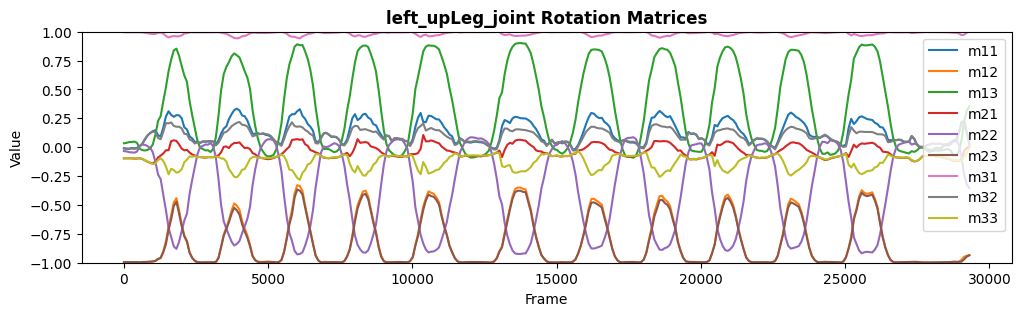

In [17]:
fig, ax = plt.subplots(figsize=(12, 3))
for i, col in enumerate(COLUMNS):
    data = df_joint[col]
    label = LABELS[i]
    ax.plot(data, label=label)

ax.set_xlabel('Frame')
ax.set_ylabel('Value')
ax.set_title('left_upLeg_joint Rotation Matrices', fontweight='bold')
ax.legend()
plt.ylim(-1, 1)
plt.show()


### Efficiently Visualizing 3D Joint Rotation Matrices

In this Python code, we efficiently visualize rotation matrices for a 'left_upLeg_joint.' We filter data, dynamically generate column names and labels, and arrange them into a 3x3 grid of subplots for easy interpretation. Our solution is concise, readable, and designed for efficiency.


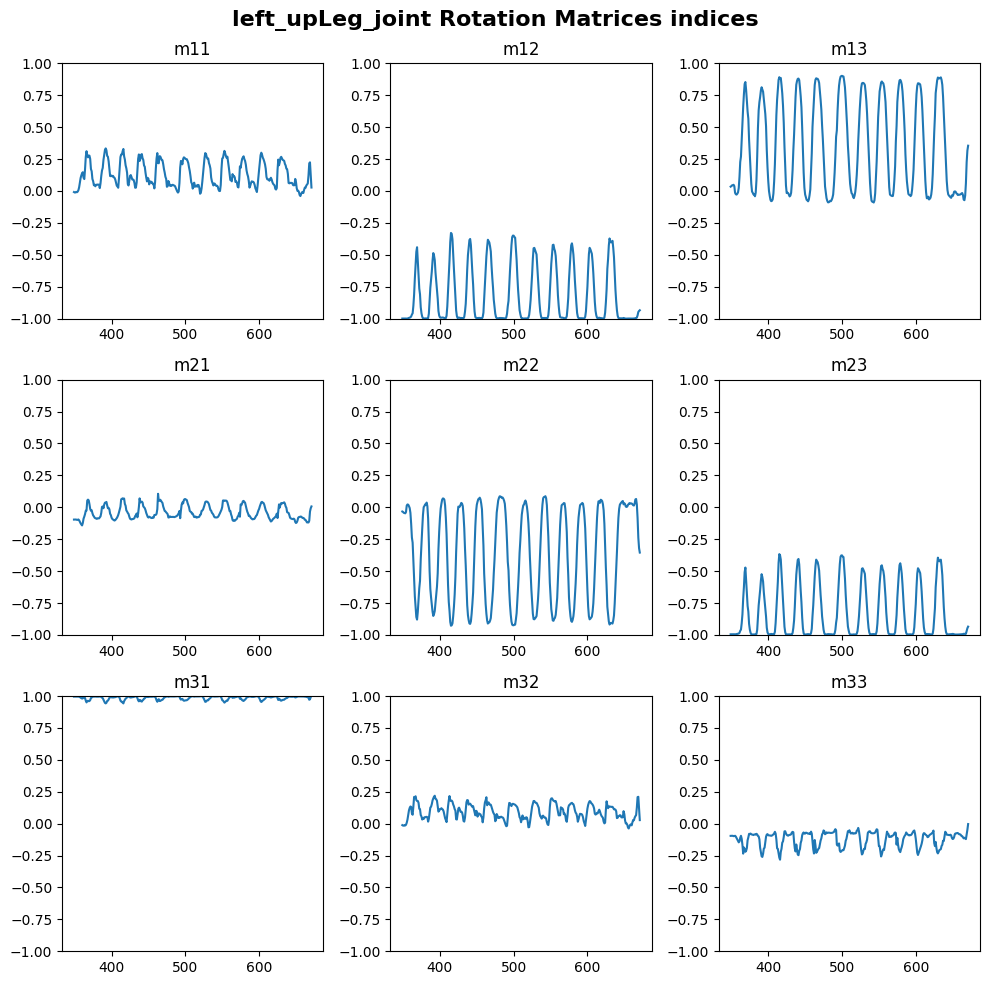

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for idx, (col, label) in enumerate(zip(COLUMNS, LABELS)):
    row_idx, col_idx = divmod(idx, 3)
    ax = axes[row_idx, col_idx]
    ax.plot(df_joint['Frame_Order'], df_joint[col], label=label)
    ax.set_ylim(-1, 1)
    ax.set_title(label)

fig.suptitle('left_upLeg_joint Rotation Matrices indices', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

## Analyzing Cycles

In this code, we define a function `select_column_with_largest_difference` to find the column with the largest difference between its maximum and minimum values within a specified range of data. We apply this function to a DataFrame `df_joint` with a list of columns `columns` and calculate the number of values to exclude from both the beginning and end. This function encapsulates the logic for selecting columns with large variations, promoting code reuse and readability.

We use the function `find_cycle_ranges` to analyze cyclic patterns within time-series data. This involves determining the column with the largest difference in the provided dataset. Next, we calculate smoothed values based on that selected column. The function identifies cycles by detecting significant peaks and prints their start and end points, along with the total number of cycles found.


In [26]:
# cmmt
EXCLUDE_COUNT = len(df_joint) // 5


def select_column_with_largest_difference(df_joint, columns_to_plot, exclude_count):
    column_diffs = {}

    for column in columns_to_plot:
        values_to_calculate = df_joint[column].iloc[exclude_count:-exclude_count]
        max_value = values_to_calculate.max()
        min_value = values_to_calculate.min()
        diff = abs(max_value - min_value)
        column_diffs[column] = diff

    return max(column_diffs, key=column_diffs.get)


def find_cycle_ranges(df_joint, columns, exclude_count, ema_window, ema_window_diff, debug=True):
    # Determine the column with the largest difference
    largest_diff = select_column_with_largest_difference(df_joint, columns, exclude_count)
    # Calculate smoothed_values based on the selected column
    smoothed_values = df_joint[largest_diff].ewm(span=ema_window, adjust=False).mean()
    smoothed_diff = smoothed_values.diff()
    smoothed_diff_smoothed = smoothed_diff.ewm(span=ema_window_diff, adjust=False).mean()

    negative_to_positive = np.where(np.diff(np.sign(smoothed_diff_smoothed)) == -2)[0]
    peaks_in_smoothed_values = smoothed_values.index[negative_to_positive]
    cycle_ranges = [(peaks_in_smoothed_values[i - 1], peaks_in_smoothed_values[i]) for i in range(1, len(peaks_in_smoothed_values))]
    total_cycles = len(cycle_ranges)
    
    if debug:
        print(f"Selected Column with Largest Difference: {largest_diff}")
        print(f"Total Cycles for {largest_diff}: {total_cycles}")
        for i, (cycle_start, cycle_end) in enumerate(cycle_ranges, start=1):
            print(f"{largest_diff} - Cycle {i}: Start at {cycle_start}, End at {cycle_end}")

    return cycle_ranges


_ = find_cycle_ranges(df_joint, COLUMNS, EXCLUDE_COUNT, EMA_WINDOW, EMA_WINDOW_DIFF)

Selected Column with Largest Difference: Local_Transform_col1_y
Total Cycles for Local_Transform_col1_y: 11
Local_Transform_col1_y - Cycle 1: Start at 1003, End at 3278
Local_Transform_col1_y - Cycle 2: Start at 3278, End at 5462
Local_Transform_col1_y - Cycle 3: Start at 5462, End at 7646
Local_Transform_col1_y - Cycle 4: Start at 7646, End at 9921
Local_Transform_col1_y - Cycle 5: Start at 9921, End at 12742
Local_Transform_col1_y - Cycle 6: Start at 12742, End at 15654
Local_Transform_col1_y - Cycle 7: Start at 15654, End at 18020
Local_Transform_col1_y - Cycle 8: Start at 18020, End at 20295
Local_Transform_col1_y - Cycle 9: Start at 20295, End at 22570
Local_Transform_col1_y - Cycle 10: Start at 22570, End at 24936
Local_Transform_col1_y - Cycle 11: Start at 24936, End at 28940


## Animated Visualization of Cycles

We define an `animate` function that creates animated visualizations of cycles in time-series data. The function takes parameters such as the current animation frame, axis, cycle ranges, data column, DataFrame, color map, and maximum cycle duration. It clears the axis, sets labels and titles, and plots cycles based on the provided parameters.

To use this function effectively, call it within a loop that iterates through cycle ranges and data columns, creating animated visualizations for each combination. This is a valuable approach for analyzing periodic patterns in time-series data.


In [31]:
# Define the animate function
def animate(i, ax, cycle_lines, cycle_ranges, column, df_joint, color_map, max_cycle_duration):
    ax.clear()
    ax.set_xlabel('Frame')
    ax.set_ylabel('Values')
    ax.set_title(f'{column}')

    # Plot all the cycle lines so far
    for line in cycle_lines:
        ax.add_line(line)

    current_cycle_idx = i % len(cycle_ranges)
    cycle_start, cycle_end = cycle_ranges[current_cycle_idx]
    cycle_duration = cycle_end - cycle_start
    cropped_cycle_values = df_joint[column].loc[cycle_start:cycle_end]
    shifted_x = cropped_cycle_values.index - cycle_start

    # Plot the cycle of the current column
    color = color_map(current_cycle_idx / len(cycle_ranges))
    line = ax.plot(shifted_x, cropped_cycle_values, color=color)[0]

    cycle_lines.append(line)
    # Set x-axis limits to match the maximum cycle duration
    ax.set_xlim(0, max_cycle_duration)
    ax.set_ylim(-1, 1)


## Analyzing and Visualizing Time-Series Data

This code performs the following tasks:
1. Determines the column with the largest difference in a given dataset.
2. Calculates cycle ranges based on the selected column.
3. Defines a color map for visualization.
4. Calculates the maximum cycle duration.
5. Creates animations for the selected column's cycles and displays them inline.

The resulting animations are saved as GIF files and stored in the `all_animations` list.

Enjoy exploring and visualizing your time-series data!


In [38]:
# Determine if the user wants to save plots to the output directory
save_plots = input(f"save results{OUTPUT_DIR}? (y/n):").strip().lower()

if save_plots in ["Y","y","yes"]:
    save_plots = True
    # Create the output directory if it doesn't exist
    os.makedirs(OUTPUT_DIR, exist_ok=True)
else:
    save_plots = False

# Determine the column with the largest difference
selected_column = select_column_with_largest_difference(df_joint, COLUMNS, EXCLUDE_COUNT)
rotation_m_index_df = [selected_column]

# Calculate cycle_ranges using the find_and_print_cycle_ranges function
cycle_ranges = find_cycle_ranges(df_joint, COLUMNS, EXCLUDE_COUNT, EMA_WINDOW, EMA_WINDOW_DIFF, debug=False)

# Define the color_map variable
color_map = cm.get_cmap('tab20')

# Calculate max_cycle_duration
max_cycle_duration = max([cycle_end - cycle_start for cycle_start, cycle_end in cycle_ranges])

all_animations = []

# Loop through all COLUMNS in the "COLUMNS" list
for column in COLUMNS:
    fig, ax = plt.subplots(figsize=(10, 6))
    cycle_lines = []

    animation = FuncAnimation(fig, animate, fargs=(ax, cycle_lines, cycle_ranges, column, df_joint, color_map, max_cycle_duration),
                            frames=len(cycle_ranges), interval=1000, repeat=True, repeat_delay=2000)

    display(HTML(animation.to_jshtml()))  # Display the animation inline

    if save_plots:
        filename = os.path.join(OUTPUT_DIR, f'{column}_animation.gif')
        animation.save(filename, writer='Pillow')

    all_animations.append(filename if save_plots else None)
    plt.close('all')

plt.show()

if save_plots:
    print(f"Plots saved to the '{OUTPUT_DIR}' directory.")
else:
    print("Plots were not saved.")


/var/folders/2w/7mtcxbyx6v1c8q51wx9j3l7h0000gn/T/ipykernel_3680/780197678.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('tab20')


MovieWriter Pillow unavailable; using Pillow instead.


MovieWriter Pillow unavailable; using Pillow instead.


MovieWriter Pillow unavailable; using Pillow instead.


MovieWriter Pillow unavailable; using Pillow instead.


MovieWriter Pillow unavailable; using Pillow instead.


MovieWriter Pillow unavailable; using Pillow instead.


MovieWriter Pillow unavailable; using Pillow instead.


MovieWriter Pillow unavailable; using Pillow instead.


MovieWriter Pillow unavailable; using Pillow instead.


Plots saved to the './outputs/' directory.
